<a href="https://colab.research.google.com/github/Vamsi995/Exploring-Language-Model-Behaviours-Using-LIT/blob/main/LIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Interpretability Tool



## Installation

In [ ]:
# Install LIT Library
!pip install lit-nlp

In [ ]:
# Installing huggingface datasets library
!pip install datasets

In [ ]:
# Installing hugginface transformer library
!pip install transformers

In [ ]:
# Imports
import attr
import pandas as pd

from lit_nlp import notebook
from lit_nlp.examples.glue import data
from lit_nlp.examples.glue import models
from lit_nlp.api.dataset import Dataset
from lit_nlp.api import types as lit_types
from datasets import load_dataset
from lit_nlp.api import layout
from matplotlib import pyplot as plt
import seaborn as sns


# Dataset Exploration

In [ ]:
# Custom Dataset Class
class SST2Dataset(Dataset):

  SPLITS: set[str] = {'validation', 'test', 'train'}
  LABELS: list[int] = ['0', '1']
  DATASET_NAME: str = "stanfordnlp/sst2"
  DATASET = load_dataset(DATASET_NAME)


  def __init__(self, split):

    if split not in self.SPLITS:
      raise ValueError(f'Split Name {split} not supported, available splits are {list(self.SPLITS)}')

    # Loading dataset from huggingface
    df = pd.DataFrame(self.DATASET[split])

    self._examples = [{
      'sentence': row['sentence'],
      'label': str(row['label'])
    } for _, row in df.iterrows()]

    print(f"Number of {split} datapoints: {len(self)}")


  @classmethod
  def init_spec(cls) -> lit_types.Spec:
    return {
        'split': lit_types.String(
            default='validation', required=True
        )
    }


  def spec(self):

    return {
        'sentence': lit_types.TextSegment(),
        'label': lit_types.CategoryLabel(vocab=self.LABELS)
    }

In [ ]:
print(f"Data Splits: {SST2Dataset.SPLITS}")

Data Splits: {'train', 'test', 'validation'}


In [ ]:
# Initializing Dataset
sst2_dataset = SST2Dataset('validation') # The test dataset has no negative examples
sst2_dataset.spec()


sst2_test_dataset = SST2Dataset('test')
sst2_test_dataset.spec()

Number of validation datapoints: 872
Number of test datapoints: 1821


{'sentence': TextSegment(required=True, annotated=False, default=''),
 'label': CategoryLabel(required=True, annotated=False, default='', vocab=['0', '1'])}

In [ ]:
# Random Samples
pd.DataFrame(sst2_dataset.sample(5).examples)

,sentence,label
0,a science-fiction pastiche so lacking in origi...,0
1,"it haunts you , you ca n't forget it , you adm...",1
2,"nicks , seemingly uncertain what 's going to m...",0
3,if there 's one thing this world needs less of...,0
4,chokes on its own depiction of upper-crust dec...,0


In [ ]:
# Filtering positive and negative examples
def filter_positives(examples: data.lit_types.JsonDict) -> bool:
  if examples['label'] == '1':
    return True
  else:
    return False

def filter_negatives(examples: data.lit_types.JsonDict) -> bool:
  if examples['label'] == '0':
    return True
  else:
    return False

In [ ]:
# Positive Examples
pd.DataFrame(sst2_dataset.filter(filter_positives).sample(5).examples)

,sentence,label
0,my wife is an actress is an utterly charming f...,1
1,it 's great escapist fun that recreates a plac...,1
2,it 's an offbeat treat that pokes fun at the d...,1
3,what 's surprising about full frontal is that ...,1
4,it just may inspire a few younger moviegoers t...,1


In [ ]:
# Negative Examples
pd.DataFrame(sst2_dataset.filter(filter_negatives).sample(5).examples)

,sentence,label
0,verbinski implements every hack-artist trick t...,0
1,comes ... uncomfortably close to coasting in t...,0
2,holden caulfield did it better .,0
3,"very special effects , brilliantly bold colors...",0
4,k-19 exploits our substantial collective fear ...,0


In [ ]:
# Class Distribution
df = pd.DataFrame(sst2_dataset.examples)
label_intent = {
    "0": "negative",
    "1": "positive"
}
df['label'] = df['label'].map(label_intent)
class_distribution = df['label'].value_counts()
cd = pd.DataFrame(class_distribution)
cd

,count
label,
positive,444
negative,428


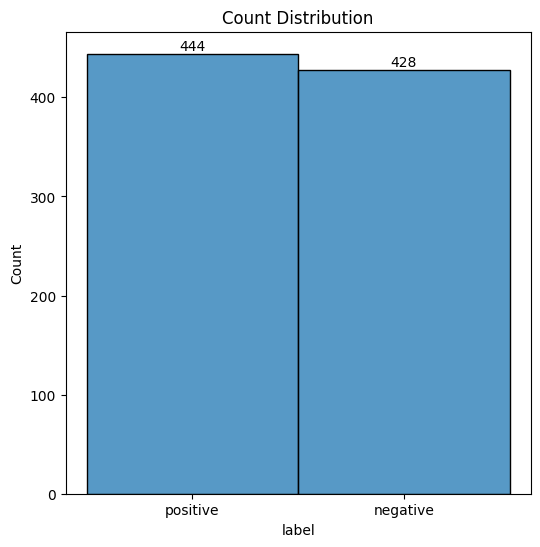

In [ ]:
# Distribution Histogram
plt.figure(figsize=(6,6))
ax = sns.histplot(df['label'])
plt.bar_label(ax.containers[0])
plt.title('Count Distribution')
plt.show()

In [ ]:
# Integrating SST2 Tiny Model (TFBertForSequenceClassification from Huggingface)
!wget https://storage.googleapis.com/what-if-tool-resources/lit-models/sst2_tiny.tar.gz
!tar -xvf sst2_tiny.tar.gz

--2024-10-23 01:59:41--  https://storage.googleapis.com/what-if-tool-resources/lit-models/sst2_tiny.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.207, 64.233.181.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16362834 (16M) [application/octet-stream]
Saving to: ‘sst2_tiny.tar.gz’

sst2_tiny.tar.gz    100%[===================>]  15.60M  50.3MB/s    in 0.3s    

2024-10-23 01:59:41 (50.3 MB/s) - ‘sst2_tiny.tar.gz’ saved [16362834/16362834]

./
./tokenizer_config.json
./tf_model.h5
./config.json
./train.history.json
./vocab.txt
./special_tokens_map.json


In [ ]:
datasets = {'sst_dev': sst2_dataset}
models = {'sst_tiny': models.SST2Model('./')}

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
modules = layout.LitModuleName

EMBEDDING_LAYOUT = layout.LitCanonicalLayout(
    upper={
        'Predictions': [
            modules.SimpleDataTableModule,
            *layout.MODEL_PREDS_MODULES,
            modules.EmbeddingsModule,
        ],
        'Explanations': [
            modules.SimpleDatapointEditorModule,
            *layout.MODEL_PREDS_MODULES,
            modules.SalienceMapModule,
            modules.LegacySequenceSalienceModule,
            *modules,
        ],
        'Analysis': [
            modules.MetricsModule,
            modules.ConfusionMatrixModule,
            modules.ScalarModule,
        ],
    },

    description='Custom layout for the Embeddings.',
)




widget = notebook.LitWidget(models, datasets, port=8890, layouts=layout.DEFAULT_LAYOUTS | {'embedding': EMBEDDING_LAYOUT},
    default_layout='embedding')

In [ ]:
# Render the widget
widget.render(height=900, open_in_new_tab=True)

In [ ]:
# Stopping the widget
widget.stop()

# Model Performance Analysis

In [ ]:
# Getting classification metrics using LIT api
from lit_nlp.components import metrics

classification_metrics = metrics.MulticlassMetrics()
classification_metrics.run(sst2_dataset.examples, models['sst_tiny'], sst2_dataset)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


[{'pred_key': 'probas',
  'label_key': 'label',
  'metrics': {'accuracy': 0.8211009174311926,
   'precision': 0.8185840707964602,
   'recall': 0.8333333333333334,
   'f1': 0.8258928571428571,
   'auc': 0.9027005977940558,
   'aucpr': 0.9121037425200402}}]

In [ ]:
modules = layout.LitModuleName

METRICS_LAYOUT = layout.LitCanonicalLayout(
    upper={
        'Predictions': [
            modules.SimpleDataTableModule,
            *layout.MODEL_PREDS_MODULES,
            modules.EmbeddingsModule,
        ],
        'Analysis': [
            modules.MetricsModule,
            modules.ConfusionMatrixModule,
            modules.ScalarModule,
        ],
    },

    description='Custom layout for the Metrics.',
)


widget = notebook.LitWidget(models, datasets, port=8891, layouts=layout.DEFAULT_LAYOUTS | {'metrics': METRICS_LAYOUT},
    default_layout='metrics')

In [ ]:
widget.render(height=900, open_in_new_tab=True)

Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

In [ ]:
widget.stop()

## Negative Sentiment Analysis

In [ ]:
# Filtering negative sentiment labels
sst2_dataset_neg = sst2_dataset.filter(filter_negatives)

In [ ]:
# Classification metrics
classification_metrics = metrics.MulticlassMetrics()
classification_metrics.run(sst2_dataset_neg.examples, models['sst_tiny'], sst2_dataset_neg)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


[{'pred_key': 'probas',
  'label_key': 'label',
  'metrics': {'accuracy': 0.8084112149532711,
   'precision': 0.0,
   'recall': 0.0,
   'f1': 0.0,
   'aucpr': -0.0}}]

In [ ]:
modules = layout.LitModuleName

METRICS_LAYOUT = layout.LitCanonicalLayout(
    upper={
        'Predictions': [
            modules.SimpleDataTableModule,
            *layout.MODEL_PREDS_MODULES,
            modules.EmbeddingsModule,
        ],
        'Analysis': [
            modules.MetricsModule,
            modules.ConfusionMatrixModule,
            modules.ScalarModule,
        ],
    },

    description='Custom layout for the Metrics.',
)

datasets = {'sst_dev': sst2_dataset_neg}

widget = notebook.LitWidget(models, datasets, port=8891, layouts=layout.DEFAULT_LAYOUTS | {'metrics': METRICS_LAYOUT},
    default_layout='metrics')

In [ ]:
widget.render(height=900, open_in_new_tab=True)

Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

In [ ]:
widget.stop()

In [ ]:
# Capturing into dataframe
sst2_dataset_neg_df = pd.DataFrame(sst2_dataset_neg.examples)

In [ ]:
# Running Predictions
preds = list(models['sst_tiny'].predict(sst2_dataset_neg.examples))
df = pd.DataFrame(preds)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
# Joining predictions with coressponding input sentences
result = pd.DataFrame(pd.concat([df, sst2_dataset_neg_df['sentence']], axis=1))

In [ ]:
result

,cls_emb,input_embs,layer_0/avg_emb,layer_1/avg_emb,layer_2/avg_emb,layer_1/attention,layer_2/attention,probas,label,tokens,tokens_sentence,input_embs_sentence,cls_grad,token_grad_sentence,sentence
0,"[-0.5334811, -1.2959057, -2.0872707, -1.427529...","[[0.017338583, -0.016962294, -0.501561, -0.010...","[-0.39826757, 0.15911253, -0.65912575, -0.1871...","[-1.7298119, -0.17571917, -0.48903856, -0.3897...","[-0.43492526, -0.80071336, 0.21594937, -0.9348...","[[[0.29993087, 0.019363632, 0.012921623, 0.096...","[[[0.07893161, 0.93537945, 0.35411224, 0.80202...","[0.8705276, 0.12947232]",0,"[[CLS], un, ##fl, ##in, ##ching, ##ly, bleak, ...","[un, ##fl, ##in, ##ching, ##ly, bleak, and, de...","[[-0.037998863, -0.024275642, 0.061621126, -0....","[-0.037814815, 0.00041138733, 0.0025079986, 0....","[[0.051446028, 0.04462846, -0.19452919, 0.0017...",unflinchingly bleak and desperate
1,"[-0.6463791, 0.06891371, -1.4176736, -1.768277...","[[0.017338583, -0.016962294, -0.501561, -0.010...","[0.009633152, 0.44124112, -0.8211326, -0.11501...","[-1.9470011, 1.0180602, -0.94865376, -0.257557...","[-0.68325764, 0.401677, 0.03033987, -1.5851989...","[[[0.3066788, 0.2215037, 0.5542305, 0.45006484...","[[[0.034146197, 0.47710633, 0.15084098, 0.1739...","[0.97357225, 0.026427716]",0,"[[CLS], it, ', s, slow, -, -, very, ,, very, s...","[it, ', s, slow, -, -, very, ,, very, slow, .]","[[-0.02315473, 0.028583972, -0.043904603, -0.0...","[-0.002057152, -0.0006151157, 0.0007737543, 0....","[[0.00035545, -0.00032099074, 0.0006647726, 0....","it 's slow -- very , very slow ."
2,"[-0.7365835, -0.32791522, -1.1239185, -2.51760...","[[0.017338583, -0.016962294, -0.501561, -0.010...","[-0.8713752, 0.36763915, -1.0882896, -0.138706...","[-1.3625767, 0.6671803, -0.57710147, -0.309141...","[-0.63377476, 0.16707325, 0.2948387, -1.447111...","[[[0.31600243, 0.80639344, 0.27915937, 0.00285...","[[[0.06215847, 0.6758493, 0.49058446, 0.656089...","[0.9204655, 0.079534434]",0,"[[CLS], a, sometimes, ted, ##ious, film, ., [S...","[a, sometimes, ted, ##ious, film, .]","[[-0.04020428, -0.0076383823, -0.00210628, -0....","[0.0010592567, 0.021598967, 0.014138677, 0.169...","[[0.015292099, 0.0066954275, -0.02780031, 0.04...",a sometimes tedious film .
3,"[0.58329517, 0.63631, -2.838591, -1.4457775, -...","[[0.017338583, -0.016962294, -0.501561, -0.010...","[0.14771731, 0.44715175, -1.0216355, -0.198360...","[-1.4154958, 1.4167227, -0.966382, -0.3175104,...","[0.144049, 0.96796036, -0.6252395, -1.0924001,...","[[[0.25043592, 0.26420915, 0.12593257, 0.53413...","[[[0.06434142, 0.8246157, 0.6095685, 0.7284781...","[0.8198207, 0.18017927]",0,"[[CLS], or, doing, last, year, ', s, taxes, wi...","[or, doing, last, year, ', s, taxes, with, you...","[[0.013928796, -0.019496849, 0.0027626788, -0....","[-0.013214307, -0.0066794725, -0.00982292, 0.2...","[[0.05062975, -0.0065926034, -0.21742009, 0.06...",or doing last year 's taxes with your ex-wife .
4,"[-0.5880306, -0.18577619, -2.6173074, -1.18181...","[[0.017338583, -0.016962294, -0.501561, -0.010...","[0.16114405, 0.34639233, -0.44015676, -0.59349...","[-1.0067116, 0.94138545, -0.55860865, -0.49356...","[-0.3791878, 0.46153718, -0.10061107, -1.15445...","[[[0.08582972, 0.45183414, 0.027695833, 0.2419...","[[[0.00847688, 0.8329099, 0.44881392, 0.163829...","[0.97042555, 0.029574595]",0,"[[CLS], in, exactly, 89, minutes, ,, most, of,...","[in, exactly, 89, minutes, ,, most, of, which,...","[[-0.011132047, -0.0225919, -0.065105245, -0.2...","[-0.002921206, 0.0008398312, -0.0032024519, 0....","[[0.0034596666, -6.9233647e-06, 0.003607301, 0...","in exactly 89 minutes , most of which passed a..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,"[0.68020076, -0.49575326, -2.0886724, 1.048010...","[[0.017338583, -0.016962294, -0.501561, -0.010...","[-0.06430842, 0.3623632, -0.16264312, -0.22400...","[-0.5231487, 0.36604005, 0.17043947, -0.209941...","[0.15992734, 0.14892259, 0.5211252, 0.4152782,...","[[[0.08310174, 0.1

In [ ]:
# Getting misclassified points
misclassified = pd.DataFrame([p for _, p in result.iterrows() if p['probas'][1] > p['probas'][0]])

In [ ]:
# Sorting them based on highest misclassification score in descending order
misclassified = pd.DataFrame(sorted([p for _, p in misclassified.iterrows()], key=lambda x: -x['probas'][1]))

In [ ]:
# Number of misclassified points
len(misclassified)

82

In [ ]:
# Top 10 misclassified sentences
pd.DataFrame(misclassified[:10]['sentence'])

,sentence
422,"it 's inoffensive , cheerful , built to inspir..."
254,although huppert 's intensity and focus has a ...
183,a great ensemble cast ca n't lift this heartfe...
389,it 's somewhat clumsy and too lethargically pa...
65,pumpkin means to be an outrageous dark satire ...
239,care deftly captures the wonder and menace of ...
142,the story and the friendship proceeds in such ...
423,while it 's genuinely cool to hear characters ...
87,"determined to be fun , and bouncy , with energ..."
36,"for all its impressive craftsmanship , and des..."


In [ ]:
# Fetching top 10 misclassified points
misclassified = misclassified[:10]

In [ ]:
# LIT Dataset filter based on sentences
def filter_sentences(examples: data.lit_types.JsonDict) -> bool:

  if examples['sentence'] in misclassified['sentence'].values:
    return True
  else:
    return False


In [ ]:
sst2_dataset_neg_pos = sst2_dataset_neg.filter(filter_sentences)

In [ ]:
modules = layout.LitModuleName

METRICS_LAYOUT = layout.LitCanonicalLayout(
    upper={
        'Predictions': [
            modules.SimpleDataTableModule,
            *layout.MODEL_PREDS_MODULES,
            modules.EmbeddingsModule,
        ],
        'Explanations': [
            modules.SimpleDatapointEditorModule,
            *layout.MODEL_PREDS_MODULES,
            modules.SalienceMapModule,
            modules.LegacySequenceSalienceModule,
        ],
        'Analysis': [
            modules.MetricsModule,
            modules.ConfusionMatrixModule,
            modules.ScalarModule,
        ],
    },

    description='Custom layout for the Metrics.',
)

datasets = {'sst_dev': sst2_dataset_neg_pos}

widget = notebook.LitWidget(models, datasets, port=8892, layouts=layout.DEFAULT_LAYOUTS | {'metrics': METRICS_LAYOUT},
    default_layout='metrics')

In [ ]:
widget.render(height=900, open_in_new_tab=True)

In [ ]:
widget.stop()

## Positive Sentiment Analysis

In [ ]:
# Filtering positive sentiment labels
sst2_dataset_pos = sst2_dataset.filter(filter_positives)

In [ ]:
# Classification Metrics
classification_metrics = metrics.MulticlassMetrics()
classification_metrics.run(sst2_dataset_pos.examples, models['sst_tiny'], sst2_dataset_pos)

[{'pred_key': 'probas',
  'label_key': 'label',
  'metrics': {'accuracy': 0.8333333333333334,
   'precision': 1.0,
   'recall': 0.8333333333333334,
   'f1': 0.9090909090909091,
   'aucpr': 0.9999999999999999}}]

In [ ]:
modules = layout.LitModuleName

METRICS_LAYOUT = layout.LitCanonicalLayout(
    upper={
        'Predictions': [
            modules.SimpleDataTableModule,
            *layout.MODEL_PREDS_MODULES,
            modules.EmbeddingsModule,
        ],
        'Analysis': [
            modules.MetricsModule,
            modules.ConfusionMatrixModule,
            modules.ScalarModule,
        ],
    },

    description='Custom layout for the Metrics.',
)

datasets = {'sst_dev': sst2_dataset_pos}

widget = notebook.LitWidget(models, datasets, port=8893, layouts=layout.DEFAULT_LAYOUTS | {'metrics': METRICS_LAYOUT},
    default_layout='metrics')

In [ ]:
widget.render(height=900, open_in_new_tab=True)

In [ ]:
widget.stop()

In [ ]:
# Capturing into dataframe
sst2_dataset_pos_df = pd.DataFrame(sst2_dataset_pos.examples)

In [ ]:
# Running Predictions
preds = list(models['sst_tiny'].predict(sst2_dataset_pos.examples))
df = pd.DataFrame(preds)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
# Joining predictions with coressponding input sentences
result_pos = pd.DataFrame(pd.concat([df, sst2_dataset_pos_df['sentence']], axis=1))

In [ ]:
result_pos

,cls_emb,input_embs,layer_0/avg_emb,layer_1/avg_emb,layer_2/avg_emb,layer_1/attention,layer_2/attention,probas,label,tokens,tokens_sentence,input_embs_sentence,cls_grad,token_grad_sentence,sentence
0,"[0.0045833588, -0.35583127, -1.0134916, 1.5898...","[[0.017338583, -0.016962294, -0.501561, -0.010...","[-0.2635093, 0.5818712, -0.85782, -0.53465885,...","[-0.47118807, 0.52927285, -0.113677464, -0.233...","[0.19051294, -0.2922655, 0.30522567, 1.1306442...","[[[0.31375167, 0.21949032, 0.5706028, 0.510833...","[[[0.08148516, 0.8215473, 0.35711917, 0.444941...","[0.008859162, 0.99114084]",1,"[[CLS], it, ', s, a, charming, and, often, aff...","[it, ', s, a, charming, and, often, affecting,...","[[-0.02315473, 0.028583972, -0.043904603, -0.0...","[0.00018687971, 4.704461e-05, 4.00652e-05, -4....","[[-7.546626e-05, -0.00011562797, 0.00026748632...",it 's a charming and often affecting journey .
1,"[0.34079966, 0.2053797, -1.594466, 1.2758322, ...","[[0.017338583, -0.016962294, -0.501561, -0.010...","[0.21094334, 0.34494534, -0.62932307, -0.49563...","[-0.0918977, 0.91472864, -0.4691346, -0.264226...","[0.5840729, 0.48886237, 0.16090326, 0.746036, ...","[[[0.1448107, 0.044249155, 0.13230214, 0.76528...","[[[0.029763037, 0.69763666, 0.8893215, 0.93077...","[0.0113946535, 0.9886054]",1,"[[CLS], allows, us, to, hope, that, nolan, is,...","[allows, us, to, hope, that, nolan, is, poised...","[[-0.004202644, 0.065549225, -0.06381365, 0.01...","[0.00020122647, -0.0011051989, -0.0001390847, ...","[[-0.0014428239, -0.00046781695, 0.0026154066,...",allows us to hope that nolan is poised to emba...
2,"[0.916946, 0.90732306, -2.097222, 0.3824364, 0...","[[0.017338583, -0.016962294, -0.501561, -0.010...","[0.09745194, 0.5520184, -0.18264368, -0.309823...","[0.12505002, 1.1675395, -0.22077195, -0.227628...","[0.43525028, 0.866634, -0.055002835, 0.2384191...","[[[0.11229771, 0.4772791, 0.08321069, 0.502560...","[[[0.028648464, 0.82742417, 0.6397514, 0.89779...","[0.03267771, 0.9673222]",1,"[[CLS], the, acting, ,, costumes, ,, music, ,,...","[the, acting, ,, costumes, ,, music, ,, cinema...","[[-0.043320682, 0.02815245, -0.027521769, -0.0...","[-0.012909416, -0.014266223, 0.00075535016, 0....","[[-0.00048740572, -0.004126703, 0.006568277, 0...","the acting , costumes , music , cinematography..."
3,"[0.27590823, -1.0817645, -0.84292114, 1.259296...","[[0.017338583, -0.016962294, -0.501561, -0.010...","[0.037663344, -0.14110626, -0.18602309, -0.280...","[-0.7623674, -0.44267917, 0.33246922, -0.14827...","[0.20100282, -0.65866363, 0.6842393, 0.7076588...","[[[0.15737812, 0.21759878, 0.011105456, 0.4934...","[[[0.016249917, 0.8166375, 0.32544354, 0.55776...","[0.00933072, 0.9906693]",1,"[[CLS], although, laced, with, humor, and, a, ...","[although, laced, with, humor, and, a, few, fa...","[[0.03739236, 0.031962592, -0.045048732, -0.02...","[-0.00010475747, -8.198773e-05, -2.4683046e-05...","[[-4.4891483e-05, -0.0003705689, 0.00080157025...",although laced with humor and a few fanciful t...
4,"[0.52883273, -0.2169162, -1.4896786, 0.8491373...","[[0.017338583, -0.016962294, -0.501561, -0.010...","[0.415785, 0.48667952, -0.2508965, -0.4571942,...","[0.054127257, 1.3525735, -0.18136007, -0.31165...","[0.97641975, 0.6652161, 0.38907057, 0.28401396...","[[[0.14710318, 0.19424811, 0.21983585, 0.10918...","[[[0.017585754, 0.90061444, 0.9287135, 0.36878...","[0.012007768, 0.98799217]",1,"[[CLS], you, do, n, ', t, have, to, know, abou...","[you, do, n, ', t, have, to, know, about, musi...","[[0.037536107, 0.020549815, 0.021361152, -0.02...","[0.00059932965, -0.00019684671, 0.0007904034, ...","[[-0.00086325215, -9.2731876e-05, -0.000967239...",you do n't have to know about music to appreci...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,"[-0.018710427, 0.36894253, -3.1072233, -0.6421...","[[0.017338583, -0.016962294, -0.501561, -0.010...","[-0.08359497, 0.1602155, -0.3976414, -0.043696...","[-1.0909047, 0.76980877, -0.27604115, -0.14382...","

In [ ]:
# Getting misclassified points
misclassified_pos = pd.DataFrame([p for _, p in result_pos.iterrows() if p['probas'][1] < p['probas'][0]])

In [ ]:
# Sorting them based on highest misclassification score in descending order
misclassified_pos = pd.DataFrame(sorted([p for _, p in misclassified_pos.iterrows()], key=lambda x: -x['probas'][0]))

In [ ]:
# Number of misclassified points
len(misclassified_pos)

74

In [ ]:
# Top 10 misclassified sentences
pd.DataFrame(misclassified_pos[:10]['sentence'])

,sentence
359,"... routine , harmless diversion and little el..."
380,a working class `` us vs. them '' opera that l...
207,"despite its title , punch-drunk love is never ..."
323,a taut psychological thriller that does n't wa...
170,a painfully funny ode to bad behavior .
385,writer/director joe carnahan 's grimy crime dr...
97,"so , too , is this comedy about mild culture c..."
102,falls neatly into the category of good stupid ...
376,it 's a demented kitsch mess ( although the sm...
294,another one of those estrogen overdose movies ...


In [ ]:
# Fetching top 10 misclassified points
misclassified_pos = misclassified_pos[:10]

In [ ]:
# LIT Dataset filter based on sentences
def filter_sentences_pos(examples: data.lit_types.JsonDict) -> bool:

  if examples['sentence'] in misclassified_pos['sentence'].values:
    return True
  else:
    return False


In [ ]:
sst2_dataset_pos_neg = sst2_dataset.filter(filter_sentences_pos)

In [ ]:
modules = layout.LitModuleName

METRICS_LAYOUT = layout.LitCanonicalLayout(
    upper={
        'Predictions': [
            modules.SimpleDataTableModule,
            *layout.MODEL_PREDS_MODULES,
            modules.EmbeddingsModule,
        ],
        'Explanations': [
            modules.SimpleDatapointEditorModule,
            *layout.MODEL_PREDS_MODULES,
            modules.SalienceMapModule,
            modules.LegacySequenceSalienceModule,
            modules.GeneratorModule,
        ],
        'Analysis': [
            modules.MetricsModule,
            modules.ConfusionMatrixModule,
            modules.ScalarModule,
        ],
    },

    description='Custom layout for the Metrics.',
)

datasets = {'sst_dev': sst2_dataset_pos_neg}

widget = notebook.LitWidget(models, datasets, port=8893, layouts=layout.DEFAULT_LAYOUTS | {'metrics': METRICS_LAYOUT},
    default_layout='metrics')

In [ ]:
widget.render(height=900, open_in_new_tab=True)

In [ ]:
widget.stop()

127.0.0.1 - - [22/Oct/2024 22:31:25] "POST /get_interpretations?authuser=2&dataset_name=sst_dev&do_predict=1&interpreter=LIME&model=roberta HTTP/1.1" 200 734


## Length based subsets

In [ ]:
lens = sorted([(len(p.split(" ")), p) for p in pd.DataFrame(sst2_dataset.examples)['sentence']], key=lambda x: -x[0])
max_len = lens[0][0]
min_len = lens[-1][0]
max_len, min_len
median = (max_len + min_len) // 2


min_len, median, max_len

(3, 25, 48)

In [ ]:
# Top 5 Longest sentences
pd.DataFrame(lens[:5])

,0,1
0,48,it 's one of those baseball pictures where the...
1,47,what really makes it special is that it pulls ...
2,46,"this is wild surreal stuff , but brilliant and..."
3,45,this is a train wreck of an action film -- a s...
4,45,slapstick buffoonery can tickle many a prescho...


In [ ]:
# Top 5 shortest sentences
pd.DataFrame(lens[-5:])

,0,1
0,5,lovely and poignant .
1,5,just not campy enough
2,4,very bad .
3,3,bad .
4,3,cool ?


In [ ]:
def filter_dataset_upper_len(examples: data.lit_types.JsonDict) -> bool:

  if len(examples['sentence'].split(" ")) >= 25:
    return True
  else:
    return False


def filter_dataset_lower_len(examples: data.lit_types.JsonDict) -> bool:

  if len(examples['sentence'].split(" ")) < 25:
    return True
  else:
    return False

In [ ]:
upper_len_dataset = sst2_dataset.filter(filter_dataset_upper_len)
lower_len_dataset = sst2_dataset.filter(filter_dataset_lower_len)

In [ ]:
len(upper_len_dataset), len(lower_len_dataset)

(275, 597)

In [ ]:
classification_metrics = metrics.MulticlassMetrics()
classification_metrics.run(upper_len_dataset.examples, models['sst_tiny'], upper_len_dataset)

[{'pred_key': 'probas',
  'label_key': 'label',
  'metrics': {'accuracy': 0.7818181818181819,
   'precision': 0.7707006369426752,
   'recall': 0.8344827586206897,
   'f1': 0.8013245033112583,
   'auc': 0.8522015915119363,
   'aucpr': 0.8626484123365901}}]

In [ ]:
classification_metrics = metrics.MulticlassMetrics()
classification_metrics.run(lower_len_dataset.examples, models['sst_tiny'], lower_len_dataset)

[{'pred_key': 'probas',
  'label_key': 'label',
  'metrics': {'accuracy': 0.8391959798994975,
   'precision': 0.8440677966101695,
   'recall': 0.8327759197324415,
   'f1': 0.8383838383838383,
   'auc': 0.9215505824785077,
   'aucpr': 0.9320284203561956}}]

In [ ]:
modules = layout.LitModuleName

METRICS_LAYOUT = layout.LitCanonicalLayout(
    upper={
        'Predictions': [
            modules.SimpleDataTableModule,
            *layout.MODEL_PREDS_MODULES,
            modules.EmbeddingsModule,
        ],
        'Explanations': [
            modules.SimpleDatapointEditorModule,
            *layout.MODEL_PREDS_MODULES,
            modules.SalienceMapModule,
            modules.LegacySequenceSalienceModule,
        ],
        'Analysis': [
            modules.MetricsModule,
            modules.ConfusionMatrixModule,
            modules.ScalarModule,
        ],
    },

    description='Custom layout for the Metrics.',
)

datasets = {'upper_len': upper_len_dataset, 'lower_len': lower_len_dataset}

widget = notebook.LitWidget(models, datasets, port=8894, layouts=layout.DEFAULT_LAYOUTS | {'metrics': METRICS_LAYOUT},
    default_layout='metrics')

In [ ]:
widget.render(height=900, open_in_new_tab=True)

In [ ]:
widget.stop()

# Models

In [ ]:
# Imports
import os
from collections.abc import Iterable, Sequence
import re
import threading
from typing import Any, Optional

import attr
from lit_nlp.api import model as lit_model
from lit_nlp.api import types as lit_types
from lit_nlp.examples.glue import model_utils
from lit_nlp.lib import file_cache
from lit_nlp.lib import utils
import numpy as np
import tensorflow as tf
import transformers
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from lit_nlp.examples.glue.models import GlueModel
import logging

JsonDict = lit_types.JsonDict
Spec = lit_types.Spec
TFSequenceClassifierOutput = (
    transformers.modeling_tf_outputs.TFSequenceClassifierOutput
)

In [ ]:
# Custom DistilBertWrapper
class DistilBertSST2Wrapper(GlueModel):
  def __init__(self, model_name_or_path="distilbert/distilbert-base-uncased-finetuned-sst-2-english", **config_kw):
      # super().__init__(model_name_or_path, **config_kw)
      self.config = AutoConfig.from_pretrained(model_name_or_path, **config_kw)
      self._load_model(model_name_or_path)
      self._lock = threading.Lock()

  def _load_model(self, model_name_or_path):
      self.model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, config=self.config)
      self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

      self.tokenizer = transformers.AutoTokenizer.from_pretrained(
          model_name_or_path
      )
      self.vocab = self.tokenizer.convert_ids_to_tokens(
          range(len(self.tokenizer))
      )
      self.config.labels = ['0', '1']
      self.config.output_attention = True
      self.config.text_a_name = "sentence"
      self.config.text_b_name = None
      self.config.label_name: str = "label"
      self.config.output_embeddings: bool = True
      self.config.null_label_idx=0
      self.config.compute_grads: bool = True
      self.config.max_seq_length: int = 128
      self.config.inference_batch_size: int = 32

      model_config = transformers.AutoConfig.from_pretrained(
          model_name_or_path,
          num_labels=1 if self.is_regression else len(self.config.labels),
          return_dict=False,  # default for training; overridden for predict
          output_attentions=self.config.output_attention,
      )
      self.model = self.load_pretrained(
          transformers.TFAutoModelForSequenceClassification,
          model_name_or_path,
          config=model_config,
          ignore_mismatched_sizes=True,
      )
      print(self.model)

  def get_embedding_table(self):
    # TODO(b/236276775): Unify on the TFBertEmbeddings.weight API after
    # transformers is updated to v4.25.1 (or newer).
    if hasattr(self.model.distilbert.embeddings, "word_embeddings"):
      return self.vocab, self.model.distilbert.embeddings.word_embeddings.numpy()
    else:
      return self.vocab, self.model.distilbert.embeddings.weight.numpy()
  def predict_minibatch(self, inputs: Iterable[JsonDict]):
    # Use watch_accessed_variables to save memory by having the tape do nothing
    # if we don't need gradients.
    with tf.GradientTape(
        watch_accessed_variables=self.config.compute_grads
    ) as tape:
      encoded_input = self._preprocess(inputs)

      # Gathers word embeddings from BERT model embedding layer using input ids
      # of the tokens.
      input_ids = encoded_input["input_ids"]
      word_embeddings = self.model.distilbert.embeddings.weight
      # <tf.float32>[batch_size, num_tokens, emb_size]
      input_embs = tf.gather(word_embeddings, input_ids)

      # Scatter in any passed in embeddings.
      # <tf.float32>[batch_size, num_tokens, emb_size]
      input_embs = self.scatter_all_embeddings(inputs, input_embs)

      tape.watch(input_embs)  # Watch input_embs for gradient calculation.

      model_inputs = encoded_input.copy()
      model_inputs["input_ids"] = None
      out: TFSequenceClassifierOutput = self.model(
          model_inputs,
          inputs_embeds=input_embs,
          training=False,
          output_hidden_states=True,
          output_attentions=True,
          return_dict=True,
      )

      batched_outputs = {
          "input_ids": encoded_input["input_ids"],
          "ntok": tf.reduce_sum(encoded_input["attention_mask"], axis=1),
          "cls_emb": out.hidden_states[-1][:, 0],  # last layer, first token
      }

      if self.config.output_embeddings:
        batched_outputs["input_embs"] = input_embs

        self._verify_num_layers(out.hidden_states)

        # <float32>[batch_size, num_tokens, 1]
        token_mask = tf.expand_dims(
            tf.cast(encoded_input["attention_mask"], tf.float32), axis=2
        )
        # <float32>[batch_size, 1]
        denom = tf.reduce_sum(token_mask, axis=1)
        for i, layer_output in enumerate(out.hidden_states):
          # layer_output is <float32>[batch_size, num_tokens, emb_dim]
          # average over tokens to get <float32>[batch_size, emb_dim]
          batched_outputs[f"layer_{i}/avg_emb"] = (
              tf.reduce_sum(layer_output * token_mask, axis=1) / denom
          )

      if self.config.output_attention:
        if len(out.attentions) != self.model.config.num_hidden_layers:
          raise ValueError(
              "Unexpected size of attentions. Should be the same "
              "size as the number of hidden layers. Expected "
              f"{self.model.config.num_hidden_layers}, got "
              f"{len(out.attentions)}."
          )
        for i, layer_attention in enumerate(out.attentions):
          batched_outputs[f"layer_{i+1}/attention"] = layer_attention

      if self.is_regression:
        # <tf.float32>[batch_size]
        batched_outputs["score"] = tf.squeeze(out.logits, axis=-1)
        # <tf.float32>[batch_size], a single target per example
        scalar_targets = batched_outputs["score"]
      else:
        # <tf.float32>[batch_size, num_labels]
        batched_outputs["probas"] = tf.nn.softmax(out.logits, axis=-1)
        # <tf.float32>[batch_size], a single target per example
        scalar_targets, grad_idxs = self.get_target_scores(
            inputs, batched_outputs["probas"]
        )
        # TODO(b/294613507): remove once TCAV updated.
        if self.config.compute_grads:
          batched_outputs[self.config.label_name] = tf.convert_to_tensor(
              grad_idxs
          )

    # Request gradients after the tape is run.
    # Note: embs[0] includes position and segment encodings, as well as subword
    # embeddings.
    if self.config.compute_grads:
      # <tf.float32>[batch_size, num_tokens, emb_dim]
      batched_outputs["input_emb_grad"] = tape.gradient(
          scalar_targets, input_embs
      )

    detached_outputs = {
        k: v.numpy()
        for k, v in batched_outputs.items()
        if v is not None
    }
    # Sequence of dicts, one per example.
    unbatched_outputs = utils.unbatch_preds(detached_outputs)
    return map(self._postprocess, unbatched_outputs)


  def load_pretrained(self, cls, *args, **kw):
    """Load a transformers model in TF2, with fallback to PyTorch weights."""
    try:
      return cls.from_pretrained(*args, **kw)
    except OSError as e:
      logging.warning("Caught OSError loading model: %s", e)
      logging.warning(
          "Re-trying to convert from PyTorch checkpoint (from_pt=True)")
      return cls.from_pretrained(*args, from_pt=True, **kw)



In [ ]:
# Custom RoBertaWrapper
class RoBertaSST2Wrapper(GlueModel):
  def __init__(self, model_name_or_path="syedkhalid076/RoBERTa-Sentimental-Analysis-Model", **config_kw):
      # super().__init__(model_name_or_path, **config_kw)
      self.config = AutoConfig.from_pretrained(model_name_or_path, **config_kw)
      self._load_model(model_name_or_path)
      self._lock = threading.Lock()

  def _load_model(self, model_name_or_path):
      self.model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, config=self.config)
      self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

      self.tokenizer = transformers.AutoTokenizer.from_pretrained(
          model_name_or_path
      )
      self.vocab = self.tokenizer.convert_ids_to_tokens(
          range(len(self.tokenizer))
      )
      self.config.labels = ['0', '1']
      self.config.output_attention = True
      self.config.text_a_name = "sentence"
      self.config.text_b_name = None
      self.config.label_name: str = "label"
      self.config.output_embeddings: bool = True
      self.config.null_label_idx=0
      self.config.compute_grads: bool = True
      self.config.max_seq_length: int = 128
      self.config.inference_batch_size: int = 32

      model_config = transformers.AutoConfig.from_pretrained(
          model_name_or_path,
          num_labels=1 if self.is_regression else len(self.config.labels),
          return_dict=False,  # default for training; overridden for predict
          output_attentions=self.config.output_attention,
      )
      self.model = self.load_pretrained(
          transformers.TFAutoModelForSequenceClassification,
          model_name_or_path,
          config=model_config,
          ignore_mismatched_sizes=True,
      )
      print(self.model)

  def get_embedding_table(self):
    # TODO(b/236276775): Unify on the TFBertEmbeddings.weight API after
    # transformers is updated to v4.25.1 (or newer).
    if hasattr(self.model.roberta.embeddings, "word_embeddings"):
      return self.vocab, self.model.roberta.embeddings.word_embeddings.numpy()
    else:
      return self.vocab, self.model.roberta.embeddings.weight.numpy()
  def predict_minibatch(self, inputs: Iterable[JsonDict]):
    # Use watch_accessed_variables to save memory by having the tape do nothing
    # if we don't need gradients.
    with tf.GradientTape(
        watch_accessed_variables=self.config.compute_grads
    ) as tape:
      encoded_input = self._preprocess(inputs)

      # Gathers word embeddings from BERT model embedding layer using input ids
      # of the tokens.
      input_ids = encoded_input["input_ids"]
      word_embeddings = self.model.roberta.embeddings.weight
      # <tf.float32>[batch_size, num_tokens, emb_size]
      input_embs = tf.gather(word_embeddings, input_ids)

      # Scatter in any passed in embeddings.
      # <tf.float32>[batch_size, num_tokens, emb_size]
      input_embs = self.scatter_all_embeddings(inputs, input_embs)

      tape.watch(input_embs)  # Watch input_embs for gradient calculation.

      model_inputs = encoded_input.copy()
      model_inputs["input_ids"] = None
      out: TFSequenceClassifierOutput = self.model(
          model_inputs,
          inputs_embeds=input_embs,
          training=False,
          output_hidden_states=True,
          output_attentions=True,
          return_dict=True,
      )

      batched_outputs = {
          "input_ids": encoded_input["input_ids"],
          "ntok": tf.reduce_sum(encoded_input["attention_mask"], axis=1),
          "cls_emb": out.hidden_states[-1][:, 0],  # last layer, first token
      }

      if self.config.output_embeddings:
        batched_outputs["input_embs"] = input_embs

        self._verify_num_layers(out.hidden_states)

        # <float32>[batch_size, num_tokens, 1]
        token_mask = tf.expand_dims(
            tf.cast(encoded_input["attention_mask"], tf.float32), axis=2
        )
        # <float32>[batch_size, 1]
        denom = tf.reduce_sum(token_mask, axis=1)
        for i, layer_output in enumerate(out.hidden_states):
          # layer_output is <float32>[batch_size, num_tokens, emb_dim]
          # average over tokens to get <float32>[batch_size, emb_dim]
          batched_outputs[f"layer_{i}/avg_emb"] = (
              tf.reduce_sum(layer_output * token_mask, axis=1) / denom
          )

      if self.config.output_attention:
        if len(out.attentions) != self.model.config.num_hidden_layers:
          raise ValueError(
              "Unexpected size of attentions. Should be the same "
              "size as the number of hidden layers. Expected "
              f"{self.model.config.num_hidden_layers}, got "
              f"{len(out.attentions)}."
          )
        for i, layer_attention in enumerate(out.attentions):
          batched_outputs[f"layer_{i+1}/attention"] = layer_attention

      if self.is_regression:
        # <tf.float32>[batch_size]
        batched_outputs["score"] = tf.squeeze(out.logits, axis=-1)
        # <tf.float32>[batch_size], a single target per example
        scalar_targets = batched_outputs["score"]
      else:
        # <tf.float32>[batch_size, num_labels]
        batched_outputs["probas"] = tf.nn.softmax(out.logits, axis=-1)
        # <tf.float32>[batch_size], a single target per example
        scalar_targets, grad_idxs = self.get_target_scores(
            inputs, batched_outputs["probas"]
        )
        # TODO(b/294613507): remove once TCAV updated.
        if self.config.compute_grads:
          batched_outputs[self.config.label_name] = tf.convert_to_tensor(
              grad_idxs
          )

    # Request gradients after the tape is run.
    # Note: embs[0] includes position and segment encodings, as well as subword
    # embeddings.
    if self.config.compute_grads:
      # <tf.float32>[batch_size, num_tokens, emb_dim]
      batched_outputs["input_emb_grad"] = tape.gradient(
          scalar_targets, input_embs
      )

    detached_outputs = {
        k: v.numpy()
        for k, v in batched_outputs.items()
        if v is not None
    }
    # Sequence of dicts, one per example.
    unbatched_outputs = utils.unbatch_preds(detached_outputs)
    return map(self._postprocess, unbatched_outputs)


  def load_pretrained(self, cls, *args, **kw):
    """Load a transformers model in TF2, with fallback to PyTorch weights."""
    try:
      return cls.from_pretrained(*args, **kw)
    except OSError as e:
      logging.warning("Caught OSError loading model: %s", e)
      logging.warning(
          "Re-trying to convert from PyTorch checkpoint (from_pt=True)")
      return cls.from_pretrained(*args, from_pt=True, **kw)



In [ ]:
# Loading DistilBert Model into LIT
models['distilbert'] = DistilBertSST2Wrapper()

In [ ]:
# Loading RoBerta Model into LIT
models['roberta'] = RoBertaSST2Wrapper()

In [ ]:
modules = layout.LitModuleName

METRICS_LAYOUT = layout.LitCanonicalLayout(
    upper={
        'Predictions': [
            modules.SimpleDataTableModule,
            *layout.MODEL_PREDS_MODULES,
            modules.EmbeddingsModule,
        ],
        'Explanations': [
            modules.SimpleDatapointEditorModule,
            *layout.MODEL_PREDS_MODULES,
            modules.SalienceMapModule,
            modules.LegacySequenceSalienceModule,
        ],
        'Analysis': [
            modules.MetricsModule,
            modules.ConfusionMatrixModule,
            modules.ScalarModule,
        ],
    },

    description='Custom layout for the Metrics.',
)

# datasets = {'upper_len': upper_len_dataset, 'lower_len': lower_len_dataset}
datasets = {'sst_dev': sst2_dataset}

widget = notebook.LitWidget(models, datasets, port=8895, layouts=layout.DEFAULT_LAYOUTS | {'metrics': METRICS_LAYOUT},
    default_layout='metrics')

In [ ]:
widget.render(height=900, open_in_new_tab=True)

In [ ]:
widget.stop()

In [ ]:
# Classification Metrics for DistilBert
classification_metrics = metrics.MulticlassMetrics()
classification_metrics.run(sst2_dataset.examples, models['distilbert'], sst2_dataset)

In [ ]:
# Classification Metrics for RoBerta
classification_metrics = metrics.MulticlassMetrics()
classification_metrics.run(sst2_dataset.examples, models['roberta'], sst2_dataset)

# Counterfactual Generator


In [ ]:
from lit_nlp.components import scrambler
scrambler = scrambler.Scrambler()

sc_in = sst2_dataset.examples[:5]
sc_out = scrambler.generate_all(sc_in, model=None, dataset=sst2_dataset,
                         config={'Fields to scramble': ['sentence']})
sc_out

[[{'sentence': "it affecting often 's  journey a . charming and",
   'label': '1'}],
 [{'sentence': 'desperate bleak unflinchingly  and', 'label': '0'}],
 [{'sentence': 'yet nolan a filmmaker hope embark inventive major to a as that us commercial  is poised to . allows career',
   'label': '1'}],
 [{'sentence': "austere acting , are locales given production , cinematography 's astounding all the costumes the , . and  music sound",
   'label': '1'}],
 [{'sentence': "very slow it -- . very 's  slow ,", 'label': '0'}]]